# Import Libraries

In [1]:
%pylab inline
import numpy as np
import pandas as pd

from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation, Bidirectional, Merge, Dropout, Reshape
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.metrics import mean_squared_error
from keras.regularizers import l2
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor

from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse

from IPython.display import display
from IPython.display import SVG, Image
from keras.utils.vis_utils import model_to_dot

Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.
/usr/local/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Data

[S&P 500 (^GSPC)](https://finance.yahoo.com/quote/%5EGSPC/history?period1=-631184400&period2=1499612400&interval=1d&filter=history&frequency=1d) 에서 1950/01/01 부터 07/07/2017년까지의 데이터를 받았습니다.<br>
테스트용으로서 Dataset전체에 대해서 standardization을 했습니다.

train_x: (13557, 38, 5)
train_y: (13557, 1)
test_x : (3390, 38, 5)
test_y : (3390, 1)


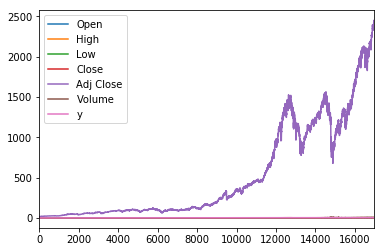

In [2]:
BATCH_SIZE = 38
LAG_SIZE = 1
TRAINING_SIZE = 400

raw_data = pd.read_csv('./GSPC.csv')
raw_data['Date'] = pd.to_datetime(raw_data['Date'])
# raw_data = raw_data[::-1]

def preprocess(data):
    X_COLUMNS = ['Open', 'High', 'Low', 'Close', 'Volume']
    Y_COLUMNS = ['y']
    COLUMNS = X_COLUMNS + Y_COLUMNS
    
    # Standardization
    scaler = StandardScaler()
    data[X_COLUMNS] = scaler.fit_transform(data[X_COLUMNS])
    
    # Create Y
    # 반드시 Standardization이후에 와야 함
    data['y'] = data.Close.shift(-1)
    data = data.dropna()
    
    # BATCH
    data = data[:data.shape[0]-data.shape[0]%BATCH_SIZE]
    data = data[COLUMNS].as_matrix()

    # Split X and Y
    N = data.shape[0]-BATCH_SIZE -1
    data_x = np.zeros((N, BATCH_SIZE, 5))
    data_y = np.zeros((N, 1))
    
    for i in range(N):
        end = i + BATCH_SIZE + 1
        series = data[i:end]
        
        data_x[i, :] = series[:BATCH_SIZE, :-1].reshape(BATCH_SIZE, 5)
        data_y[i] = series[BATCH_SIZE:, -1]
    
    return scaler, data_x, data_y

def split_train_test(data_x, data_y, test_size=0.2):
    train_size = int(data_y.shape[0] * (1-test_size))
    
    train_x, test_x = data_x[:train_size], data_x[train_size:]
    train_y, test_y = data_y[:train_size], data_y[train_size:]
        
    return train_x, train_y, test_x, test_y
    
scaler, data_x, data_y = preprocess(raw_data)
train_x, train_y, test_x, test_y = split_train_test(data_x, data_y)

print('train_x:', train_x.shape)
print('train_y:', train_y.shape)
print('test_x :', test_x.shape)
print('test_y :', test_y.shape)

raw_data.plot()

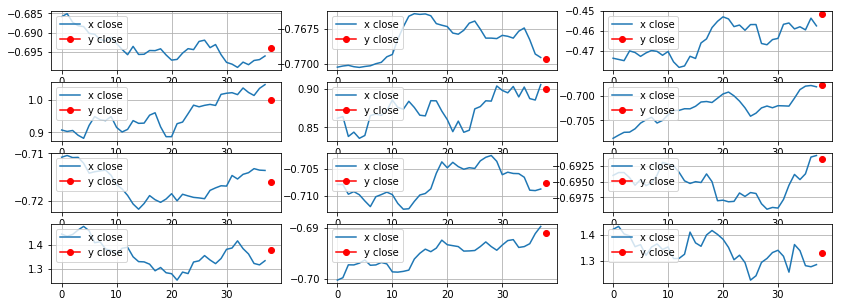

In [3]:
def visualize_data(x, y):
    f, plots = subplots(4, 3)
    f.set_figheight(5)
    f.set_figwidth(14)
    plots = plots.reshape(-1)
    
    for p in plots:
        idx = np.random.randint(x.shape[0])
        t = np.arange(BATCH_SIZE+1)
        p.plot(t[:-1], x[idx, :, 3], label="x close")
        p.plot(t[-1], y[idx], label='y close', marker='o', color='red')
        p.legend(loc='upper left')
        p.grid()
        
visualize_data(train_x, train_y)

# Model

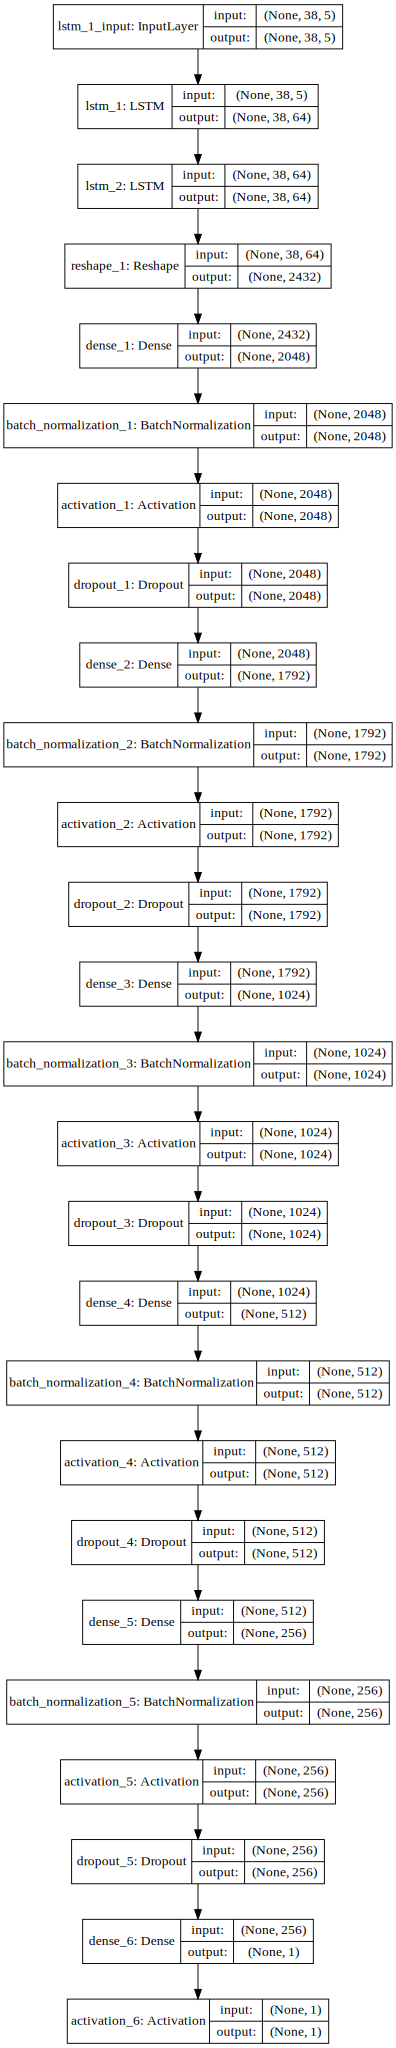

In [4]:
INPUT_N = train_x.shape[-1]
def create_model(lstm_memory=64):
    model = Sequential()
    model.add(LSTM(lstm_memory, return_sequences=True, batch_input_shape=(None, BATCH_SIZE, INPUT_N)))
    model.add(LSTM(lstm_memory, return_sequences=True))  # (2, 38, 64)
    
    model.add(Reshape((BATCH_SIZE*lstm_memory,), 
                      input_shape=(-1, BATCH_SIZE, lstm_memory)))  # (2, 1, 2432)
    
    model.add(Dense(2048))
    model.add(BatchNormalization())
    model.add(Activation('selu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(1792))
    model.add(BatchNormalization())
    model.add(Activation('selu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(1024))
    model.add(BatchNormalization())
    model.add(Activation('selu'))
    model.add(Dropout(0.5))
        
    model.add(Dense(512, kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(Activation('selu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(256))
    model.add(BatchNormalization())
    model.add(Activation('selu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(1))
    model.add(Activation('linear'))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=[mean_squared_error])
    return model
    
model = create_model()
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))


In [5]:
history = model.fit(train_x, train_y, verbose=2, epochs=20)

Epoch 1/20


ResourceExhaustedError: OOM when allocating tensor with shape[2432,2048]
	 [[Node: Variable_34/Assign = Assign[T=DT_FLOAT, _class=["loc:@Variable_34"], use_locking=true, validate_shape=true, _device="/job:localhost/replica:0/task:0/gpu:0"](Variable_34, Const_39)]]

Caused by op 'Variable_34/Assign', defined at:
  File "/usr/local/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/local/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/usr/local/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/usr/local/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/usr/local/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2698, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2802, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-5-e149577866ac>", line 1, in <module>
    history = model.fit(train_x, train_y, verbose=2, epochs=20)
  File "/usr/local/lib/python3.6/site-packages/keras/models.py", line 863, in fit
    initial_epoch=initial_epoch)
  File "/usr/local/lib/python3.6/site-packages/keras/engine/training.py", line 1413, in fit
    self._make_train_function()
  File "/usr/local/lib/python3.6/site-packages/keras/engine/training.py", line 937, in _make_train_function
    self.total_loss)
  File "/usr/local/lib/python3.6/site-packages/keras/optimizers.py", line 416, in get_updates
    vs = [K.zeros(K.get_variable_shape(p), dtype=K.dtype(p)) for p in params]
  File "/usr/local/lib/python3.6/site-packages/keras/optimizers.py", line 416, in <listcomp>
    vs = [K.zeros(K.get_variable_shape(p), dtype=K.dtype(p)) for p in params]
  File "/usr/local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py", line 603, in zeros
    dtype, name)
  File "/usr/local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py", line 321, in variable
    v = tf.Variable(value, dtype=_convert_string_dtype(dtype), name=name)
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 200, in __init__
    expected_shape=expected_shape)
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 309, in _init_from_args
    validate_shape=validate_shape).op
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/state_ops.py", line 271, in assign
    validate_shape=validate_shape)
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gen_state_ops.py", line 45, in assign
    use_locking=use_locking, name=name)
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2506, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1269, in __init__
    self._traceback = _extract_stack()

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[2432,2048]
	 [[Node: Variable_34/Assign = Assign[T=DT_FLOAT, _class=["loc:@Variable_34"], use_locking=true, validate_shape=true, _device="/job:localhost/replica:0/task:0/gpu:0"](Variable_34, Const_39)]]


In [ ]:
def validate(x_train, y_train, x_test, y_test):
    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)
    
    train_n = y_train_pred.shape[0]
    test_n = y_test_pred.shape[0]
    x = np.arange(train_n + test_n)
    
    plot(x[:train_n], y_train, color='#555555')
    plot(x[:train_n], y_train_pred)
    
    plot(x[train_n:], y_test, color='#555555')
    plot(x[train_n:], y_test_pred, color='red')
    
    print('TRAIN r^2 score:', r2_score(y_train_pred, y_train))
    print('TRAIN MSE score:', mse(y_train_pred, y_train))
    
    print('TEST  r^2 score:', r2_score(y_test_pred, y_test))
    print('TRAIN MSE score:', mse(y_test_pred, y_test))
    
validate(train_x, train_y, test_x, test_y)

### Test 1
```
 - epoch 10
 - mse

 - LSTM 64
 - LSTM 64
 - Reshape 
 
 - 2048
 - batch
 - selu
 
 - 1280
 - batch
 - selu
 
 - 512
 - batch
 - selu
 
 - 256
 - batch
 - selu
 
 - 1
 
TRAIN r^2 score: 0.985016345938 
TRAIN MSE score: 0.00629689728654
TEST  r^2 score: -0.929616577374
TRAIN MSE score: 0.189794574429

20번 돌리면
TRAIN r^2 score: 0.987728857903
TRAIN MSE score: 0.00501801610127
TEST  r^2 score: -0.609017352468
TRAIN MSE score: 0.230812901795
```
